# [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531)

## Introduction

Training stage and deployment stage have different requirements so should use different models: 
* Training stage model should be **good at extracting structure** from data
* Deployed model should be **efficient and computionally affordable**

Difference between Distillation and Model Compression with logits: 

* Distillation uses **temperature on softmax with Cross Entropy loss**
* Model Compression with logits uses **raw scores with MSE Loss**

When performing Distillation, can use simply **original dataset** or an **unlabeled dataset**

If using original dataset, we have the option of balancing two objectives: 
$$
L = (1 - \alpha)\,\mathrm{CE}(y, p_s) \;+\; \alpha\,T^2\,\mathrm{CE}(p_t^{(T)}, p_s^{(T)})
$$

## Approach

**Temperature**
* Temperature is a parameter that decides how soft the distribution will be. Raising the temperature raises the entropy (softness)
* Softmax by default uses temperature $T=1$.
\begin{align}
q_i = \frac{exp(z_i / T)}{\sum_j{exp(z_j / T)}}
\end{align}

In [13]:
import torch

def softmax_with_temperature(logits, temperature): 
    num = torch.exp(logits / temperature)
    den = torch.exp(logits / temperature).sum()
    return num / den

In [14]:
x = torch.tensor([10.0, 1.0, 3.0, -5.0])
print(torch.nn.functional.softmax(x, dim=-1)) # Default softmax
print(softmax_with_temperature(x, 1)) # Temperature=1 -> Default softmax

tensor([9.9897e-01, 1.2328e-04, 9.1094e-04, 3.0559e-07])
tensor([9.9897e-01, 1.2328e-04, 9.1094e-04, 3.0559e-07])


In [15]:
softmax_with_temperature(x, 10) # Temperature=10 -> More balanced

tensor([0.4703, 0.1912, 0.2335, 0.1049])

In [16]:
softmax_with_temperature(x, 1e10) # Extremely high temperature -> Max entropy (uniform distribution)

tensor([0.2500, 0.2500, 0.2500, 0.2500])

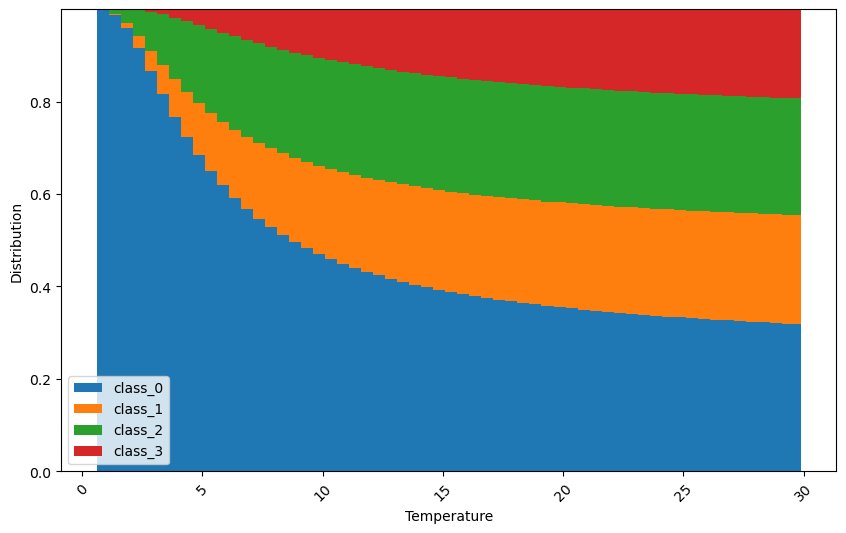

In [17]:
# Plot showing temperature's affect on distribution
import matplotlib.pyplot as plt 
import numpy as np

Ts = torch.arange(1, 30, 0.5)
dists = torch.zeros(len(Ts), len(x))
for i, T in enumerate(Ts):
    dists[i] = softmax_with_temperature(x, T)

plt.figure(figsize=(10, 6))
for i in range(len(x)):
    if i == 0:
        plt.bar(Ts, dists[:,i], label=f"class_{i}")
    else:
        plt.bar(Ts, dists[:,i], label=f"class_{i}", bottom=dists[:, :i].sum(axis=1))

plt.xlabel('Temperature')
plt.ylabel('Distribution')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Result

* Ran an experiement where distilled model (60.8% accurate) reduces the gap between student (58.9%) and teacher (61.1%) by 86%
* Proved distilled models can be trained on insufficient data
     * 98.6% accuracy on 3-class in MNIST despite never being trained on a 3 example
     * Retains similar accuracy (57%) to the same model trained on 100% of the original dataset (58.9%), even when only trained on 3% of original dataset (without distilation: 44.5%)

## Application

In [18]:
import torch
from torch import nn
import torch.nn.functional as F

# Large (complex) model with regularization (dropout)
class LargeNet(nn.Module):
    def __init__(self, input_size=(28,28), output_size=10, num_neurons=1200, p=0.2):
        super(LargeNet, self).__init__()
        self.p = p
        input_size = np.prod(input_size)
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.out = nn.Linear(num_neurons, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        # x = F.dropout(x, p=self.p)
        
        x = self.fc2(x)
        x = F.relu(x)
        # x = F.dropout(x, p=self.p)
        
        logits = self.out(x)
        return logits

# Small (distilled) model without regularization
class SmallNet(nn.Module):
    def __init__(self, input_size=(28,28), output_size=10, num_neurons=800):
        super(SmallNet, self).__init__()
        input_size = np.prod(input_size)
        self.fc1 = nn.Linear(input_size, num_neurons)
        self.fc2 = nn.Linear(num_neurons, num_neurons)
        self.out = nn.Linear(num_neurons, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        logits = self.out(x)
        return logits

In [26]:
# Data
from torchvision import datasets, transforms

# Jitter 2 pixels
jitter = 2 / 28
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=0, translate=(jitter, jitter)),
])

# Loading MNIST data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create data loaders
BATCH_SIZE = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomAffine(degrees=[0.0, 0.0], translate=(0.07142857142857142, 0.07142857142857142))
           )

In [27]:
def apply_l2_weight_constraint(model, max_norm):
    with torch.no_grad():
        for module in model.modules():
            if isinstance(module, torch.nn.Linear):
                # weight shape: [out_features, in_features]
                weight = module.weight.data
                
                norms = weight.norm(p=2, dim=1, keepdim=True)
                desired = torch.clamp(norms, max=max_norm)
                module.weight.data = weight * (desired / (norms + 1e-8))

In [28]:
from tqdm.notebook import tqdm

def train_model(model, optimizer, num_epochs=20, l2_constraint=None, gamma=0.85):
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
    
        progress_bar = tqdm(total=len(train_loader))
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.view(inputs.shape[0], -1).to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights

            if l2_constraint is not None:
                apply_l2_weight_constraint(model, l2_constraint)
            
            running_loss += loss.item() * inputs.size(0)
            
            progress_bar.update(1)
            progress_bar.set_description(f"Loss: {loss.item():.4f}")
        scheduler.step()

        next_lr = optimizer.param_groups[0]["lr"]
        all_preds, all_labels = test_model(model)
        num_instances = len(all_preds)
        correct = (all_preds == all_labels).sum()
        accuracy =  correct / num_instances
        errors = num_instances - correct
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy}, Errors: {errors}, next LR: {next_lr}")

def test_model(model):
    model.eval()
    progress_bar = tqdm(total=len(test_loader))
    
    all_preds, all_labels = [], []
    for inputs, labels in test_loader:
        inputs, labels = inputs.view(inputs.shape[0], -1).to(device), labels.to(device)
        
        outputs = model(inputs)  # Forward pass
        preds = outputs.argmax(axis=-1)
        all_preds += preds
        all_labels += labels
        progress_bar.update(1)
    all_preds, all_labels = torch.tensor(all_preds), torch.tensor(all_labels)
    return all_preds, all_labels

In [29]:
from torch import optim
import numpy as np 

LR = 1e-2
MOMENTUM = 0.9
large_model = LargeNet()
optimizer = torch.optim.SGD(large_model.parameters(), lr=LR, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
train_model(large_model, optimizer, num_epochs=30)

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.4058, Accuracy: 0.9477999806404114, Errors: 522, next LR: 0.0085


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/30, Loss: 0.1545, Accuracy: 0.9580000042915344, Errors: 420, next LR: 0.0072250000000000005


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.1152, Accuracy: 0.9668999910354614, Errors: 331, next LR: 0.00614125


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.0942, Accuracy: 0.9731000065803528, Errors: 269, next LR: 0.0052200625


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.0832, Accuracy: 0.9772999882698059, Errors: 227, next LR: 0.004437053125


  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.0734, Accuracy: 0.9783999919891357, Errors: 216, next LR: 0.0037714951562499996


  0%|          | 0/3750 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
large_preds, large_labels = test_model(large_model)

In [33]:
print("Errors: ", (large_preds != large_labels).sum().item())
print("Accuracy: ", ((large_preds == large_labels).sum() / len(large_preds)).item())

Errors:  317
Accuracy:  0.9682999849319458


In [34]:
LR = 1e-3
small_model = SmallNet()
optimizer = optim.Adam(small_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [35]:
train_model(small_model, optimizer, num_epochs=20)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/15, Loss: 0.3661, Accuracy: 0.9462000131607056, Errors: 538


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/15, Loss: 0.1353, Accuracy: 0.9678000211715698, Errors: 322


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/15, Loss: 0.1038, Accuracy: 0.97079998254776, Errors: 292


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/15, Loss: 0.0875, Accuracy: 0.9754999876022339, Errors: 245


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/15, Loss: 0.0770, Accuracy: 0.9761999845504761, Errors: 238


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/15, Loss: 0.0686, Accuracy: 0.9778000116348267, Errors: 222


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/15, Loss: 0.0636, Accuracy: 0.9781000018119812, Errors: 219


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/15, Loss: 0.0597, Accuracy: 0.9799000024795532, Errors: 201


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/15, Loss: 0.0548, Accuracy: 0.9807000160217285, Errors: 193


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/15, Loss: 0.0533, Accuracy: 0.9829000234603882, Errors: 171


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/15, Loss: 0.0502, Accuracy: 0.9821000099182129, Errors: 179


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/15, Loss: 0.0459, Accuracy: 0.9818000197410583, Errors: 182


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/15, Loss: 0.0437, Accuracy: 0.9815000295639038, Errors: 185


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/15, Loss: 0.0436, Accuracy: 0.9817000031471252, Errors: 183


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/15, Loss: 0.0398, Accuracy: 0.9815999865531921, Errors: 184


In [36]:
small_preds, small_labels = test_model(small_model)

  0%|          | 0/79 [00:00<?, ?it/s]

In [37]:
print("Errors: ", (small_preds != small_labels).sum().item())
print("Accuracy: ", ((small_preds == small_labels).sum() / len(small_preds)).item())

Errors:  189
Accuracy:  0.9811000227928162


In [38]:
def distil_model(small_model, large_model, optimizer, num_epochs=15, alpha=0.8, T=20):
    small_model = small_model.to(device)
    large_model = large_model.to(device)
    large_model.eval()
    for epoch in range(num_epochs):
        small_model.train()  # Set the small_model to training mode
        running_loss = 0.0
    
        progress_bar = tqdm(total=len(train_loader))
    
        for inputs, labels in train_loader:
            inputs, labels = inputs.view(inputs.shape[0], -1).to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the gradients

            # Forward passes
            outputs_small = small_model(inputs)
            outputs_large = large_model(inputs)
            
            with torch.no_grad():
                teacher_probs = F.softmax(outputs_large / T, dim=1)
            student_log_probs = F.log_softmax(outputs_small / T, dim=1)

            # Compute the loss
            distill_loss = F.kl_div(student_log_probs, teacher_probs, reduction="batchmean") * (T * T)
            loss = alpha * distill_loss + (1 - alpha) * criterion(outputs_small, labels) 
            
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            
            running_loss += loss.item() * inputs.size(0)
            
            progress_bar.update(1)
            progress_bar.set_description(f"Loss: {loss.item():.4f}")
        
        all_preds, all_labels = test_model(small_model)
        num_instances = len(all_preds)
        correct = (all_preds == all_labels).sum()
        accuracy =  correct / num_instances
        errors = num_instances - correct
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy}, Errors: {errors}")